In [2]:
from NutOptimizer import NutOptimizer
import pandas as pd
import numpy as np
import json
from pathlib import Path
from matplotlib import pyplot as plt
import time
from typing import List

In [3]:
start_time = time.time()

# Data Horizons Paper Models

In [6]:
conversion_factors = pd.read_csv('../data/FoodData_Central_csv_2022-04-28/food_calorie_conversion_factor.csv')
food_conversions = pd.read_csv('../data/FoodData_Central_csv_2022-04-28/food_nutrient_conversion_factor.csv')
conversions = conversion_factors.merge(food_conversions, left_on='food_nutrient_conversion_factor_id', right_on='id')

In [7]:
fp = Path('../Data Collection/guidelines/fdc_const.json')
dat_fp = Path('../brand new data/new_fdc_kroger_combined_per_serving.csv')
dat = pd.read_csv(dat_fp)
dat = dat.fillna(0)

rename_dict = {
               'Protein': 'Protein - g',
               'Carbohydrate, by difference': "Total Carbohydrate"
              }

dat = dat.rename(rename_dict, axis=1)

# Conversions: sugar from g to kcal, total lipid g to kcal, Fatty acids total saturated g to kcal, Vitamin A iu to mcg RAE
dat['Protein - cal'] = dat['Protein - g'] * 4 
dat['Carb - cal'] = dat['Total Carbohydrate'] * 4
dat['Total lipid (fat)'] *= 9
dat['Fatty acids, total saturated'] *= 9
dat['Sugars, total including NLEA'] *= 4
dat['Sugars, added'] *= 4
dat['Price per Serving'] = round(dat['Price'] / dat['No Servings'], 2)
pd.set_option('display.max_columns', 50)

In [8]:
# Clean up categories
cats = pd.read_csv('../data/categories.csv')

cats = cats[cats['Category'].isin(dat['branded_food_category'])]

def new_cat(row: pd.DataFrame):
    if pd.isna(row['Level 3 Categorization']):
        return row['Category']
    return row['Level 3 Categorization']

cats['Final Category'] = cats.apply(new_cat, axis=1)

cats_dict = {}
for idx, row in cats.iterrows():
    cats_dict[row['Category']] = row['Final Category']

In [9]:
# Add indicator columns for categories
categories = dat['branded_food_category'].unique()

for cat in categories:
    dat.loc[dat['branded_food_category'] == cat, cats_dict[cat]] = 1
    dat.loc[dat['branded_food_category'] == cat, 'final_category'] = cats_dict[cat]
    
dat = dat.fillna(0)
dat = dat[dat['Price'] != 0]
dat = dat.reset_index(drop=True)
    
# pd.set_option('display.max_columns', 250)
# dat.head()

In [10]:
# Add weights for optimization constraints
category_weights = ['Protein Foods', 'Grains']
for cat in category_weights:
    dat.loc[dat['final_category'] == cat, cat+'_wt_in_g'] = dat.loc[dat['final_category'] == cat, 'serving_size']
    
dat = dat.fillna(0)

In [11]:
# Drop Categories which we don't want
level_2_cats = cats[cats['Level 2'] == 'Include']['Category']

level_2_dat = dat[dat['branded_food_category'].isin(level_2_cats)]
level_2_dat = level_2_dat.reset_index(drop=True)

In [12]:
opt = NutOptimizer(data=dat)
opt.load_constraints_json(fp)

level_2_opt = NutOptimizer(data=level_2_dat)
level_2_opt.load_constraints_json(fp)

constraints = opt.get_models()
level_2_constraints = level_2_opt.get_models()

for name in constraints:
    if name not in ['F 31-50', 'M 31-50']:
        opt.remove_model(name)
        level_2_opt.remove_model(name)

## Original Results - No Category Restrictions

In [13]:
pd.set_option('display.max_colwidth', 500)

In [14]:
# No category restrictions
opt.optimize_all('Price per Serving', verbose=False, var_type='INTEGER')
int_res = opt.get_all_results()
int_cost = opt.get_all_optimal_values('Price per Serving')

print("Original Data - F 31-50 - Integer Optimization")
original_integer_fem_res = round(opt.get_one_optimal_value("F 31-50", "Price per Serving"),2)
original_integer_male_res = round(opt.get_one_optimal_value("M 31-50", "Price per Serving"),2)
pd.DataFrame(int_res['F 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'Amount']]

Original Data - F 31-50 - Integer Optimization


,ID,Description,branded_food_category,Price per Serving,Amount
3937,884395207721,Sun Vista® Pinto Beans,Canned & Bottled Beans,0.03,2.0
4327,50000609307,Carnation Breakfast Essentials Rich Milk Chocolate Nutritional Drink Mix,Breakfast Drinks,0.55,3.0
6249,761720987490,Mazola Corn Oil,Vegetable & Cooking Oils,0.07,1.0
7201,715141503494,Eggland's Best Large White Eggs,Eggs & Egg Substitutes,0.29,1.0
7203,715141716825,Eggland's Best Cage Free Large Brown Organic Eggs,Eggs & Egg Substitutes,0.50,1.0
7205,715141729283,Eggland's Best Extra Large White Eggs,Eggs & Egg Substitutes,0.30,2.0
7342,11110850058,Kroger® Spaghetti Noodles,Pasta by Shape & Type,0.12,2.0
10327,11110401014,Kroger® Vitamin D Whole Milk,Milk,0.20,2.0
10501,76808006490,Barilla® Whole Grain Thin Spaghetti Pasta,Pasta by Shape & Type,0.24,1.0


In [19]:
print("Original Data - M 31-50 - Integer Optimization")
pd.DataFrame(int_res['M 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'Amount']]

Original Data - M 31-50 - Integer Optimization


,ID,Description,branded_food_category,Price per Serving,Amount
2154,72310010284,Bigelow® Blackberry Citrus Herbal Tea Caffeine Free Tea Bags plus Zinc,Tea Bags,0.19,1.0
3937,884395207721,Sun Vista® Pinto Beans,Canned & Bottled Beans,0.03,3.0
4327,50000609307,Carnation Breakfast Essentials Rich Milk Chocolate Nutritional Drink Mix,Breakfast Drinks,0.55,4.0
4423,11110881328,Kroger® Sugar Free Hazelnut Coffee Creamer,Milk Additives,0.05,1.0
6249,761720987490,Mazola Corn Oil,Vegetable & Cooking Oils,0.07,2.0
7201,715141503494,Eggland's Best Large White Eggs,Eggs & Egg Substitutes,0.29,1.0
7205,715141729283,Eggland's Best Extra Large White Eggs,Eggs & Egg Substitutes,0.30,2.0
7342,11110850058,Kroger® Spaghetti Noodles,Pasta by Shape & Type,0.12,2.0
9518,41000119767,Lipton Raspberry Iced Tea Mix,Powdered Drinks,0.01,1.0
10327,11110401014,Kroger® Vitamin D Whole Milk,Milk,0.20,2.0


In [20]:
level_2_opt.optimize_all('Price per Serving', verbose=False, var_type='INTEGER')
level_2_int_res = level_2_opt.get_all_results()
level_2_int_cost = level_2_opt.get_all_optimal_values('Price per Serving')

print("Level 2 Data - F 31-50 - Integer Optimization")
level2_integer_fem_res = round(level_2_opt.get_one_optimal_value("F 31-50", "Price per Serving"),2)
level2_integer_male_res = round(level_2_opt.get_one_optimal_value("M 31-50", "Price per Serving"),2)
pd.DataFrame(level_2_int_res['F 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'Amount']]

Level 2 Data - F 31-50 - Integer Optimization


,ID,Description,branded_food_category,Price per Serving,Amount
172,884912114709,Raisin Bran Whole Grain Wheat & Bran Cereal,Cereal,0.36,1.0
267,21000604913,Kraft Singles American Cheese Slices,Cheese,0.21,1.0
1502,11110051813,Good to Dough® Enriched White Bread,Breads & Buns,0.05,1.0
4583,29000073258,Planters® Dry Roasted Peanuts,"Popcorn, Peanuts, Seeds & Related Snacks",0.23,1.0
4681,715141716825,Eggland's Best Cage Free Large Brown Organic Eggs,Eggs & Egg Substitutes,0.50,1.0
4683,715141729283,Eggland's Best Extra Large White Eggs,Eggs & Egg Substitutes,0.30,3.0
4741,11110850058,Kroger® Spaghetti Noodles,Pasta by Shape & Type,0.12,3.0
5006,71430009765,Dole Spinach,Pre-Packaged Fruit & Vegetables,0.86,1.0
5390,34856121664,Welch's Value Size Mixed Fruit Snacks,Candy,0.22,3.0
6451,16000175815,Tasty™ Chicken Tikka Masala Dinner Kit,Cereal,0.60,1.0


In [21]:
print("Level 2 Data - M 31-50 - Integer Optimization")
pd.DataFrame(level_2_int_res['M 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'Amount']]

Level 2 Data - M 31-50 - Integer Optimization


,ID,Description,branded_food_category,Price per Serving,Amount
172,884912114709,Raisin Bran Whole Grain Wheat & Bran Cereal,Cereal,0.36,2.0
1502,11110051813,Good to Dough® Enriched White Bread,Breads & Buns,0.05,1.0
2311,10700804273,Zero King Size Candy Bar,Candy,0.01,1.0
4583,29000073258,Planters® Dry Roasted Peanuts,"Popcorn, Peanuts, Seeds & Related Snacks",0.23,1.0
4681,715141716825,Eggland's Best Cage Free Large Brown Organic Eggs,Eggs & Egg Substitutes,0.50,1.0
4683,715141729283,Eggland's Best Extra Large White Eggs,Eggs & Egg Substitutes,0.30,3.0
4741,11110850058,Kroger® Spaghetti Noodles,Pasta by Shape & Type,0.12,3.0
5006,71430009765,Dole Spinach,Pre-Packaged Fruit & Vegetables,0.86,1.0
5390,34856121664,Welch's Value Size Mixed Fruit Snacks,Candy,0.22,3.0
6451,16000175815,Tasty™ Chicken Tikka Masala Dinner Kit,Cereal,0.60,1.0


In [22]:
print(f'Original F 31-50 Integer: ${original_integer_fem_res}')
print(f'Original M 31-50 Integer: ${original_integer_male_res}')

print(f'Level 2 F 31-50 Integer: ${level2_integer_fem_res}')
print(f'Level 2 M 31-50 Integer: ${level2_integer_male_res}')

Original F 31-50 Integer: $4.05
Original M 31-50 Integer: $4.45
Level 2 F 31-50 Integer: $5.07
Level 2 M 31-50 Integer: $5.23


In [23]:
original_baskets_df = pd.DataFrame()

df = pd.DataFrame(int_res['M 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'serving_size', 'Size', 'Amount']]
df['Model'] = 'Original Data - M 31-50 - Integer - No Category Constraints'
original_baskets_df = original_baskets_df.append(df)

df = pd.DataFrame(int_res['F 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'serving_size', 'Size', 'Amount']]
df['Model'] = 'Original Data - F 31-50 - Integer - No Category Constraints'
original_baskets_df = original_baskets_df.append(df)

df = pd.DataFrame(level_2_int_res['M 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'serving_size', 'Size', 'Amount']]
df['Model'] = 'Level 2 - M 31-50 - Integer - No Category Constraints'
original_baskets_df = original_baskets_df.append(df)

df = pd.DataFrame(level_2_int_res['F 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'serving_size', 'Size', 'Amount']]
df['Model'] = 'Level 2 - F 31-50 - Integer - No Category Constraints'
original_baskets_df = original_baskets_df.append(df)

## Original Results with Category Constraints

In [24]:
include_mins = True
max_per_category = 2
cats = cats[cats['Level 2'] == 'Include']
cats['Final Category'].unique()

array(['Dairy', 'Soup', 'Vegetables', 'Breakfast',
       'Other Frozen Desserts', 'Snacks', 'Grains', 'Side Dish',
       'Dough Based Products / Meals', 'Protein Foods',
       'Cooked & Prepared', 'Frozen Dinners & Entrees', 'Other Deli',
       'Candy', 'Mexican Dinner Mixes', 'Chocolate', 'Pizza', 'Fruit',
       'Frozen Bread & Dough', 'Entrees, Sides & Small Meals',
       'Pizza Mixes & Other Dry Dinners', 'Prepared Wraps and Burittos',
       'Prepared/Preserved Foods Variety Packs', 'Deli Salads',
       'Prepared Subs & Sandwiches'], dtype=object)

In [25]:
def add_category_constraints(opt: NutOptimizer, add_min: bool, max_val: int):
    # Add any additional category constraints
    const_dict = {}
    if max_val is not None:
        for cat in cats['Final Category'].unique():
            # Add in any additional constraints here
            const_dict[cat] = max_val

#     del const_dict['0']
    del const_dict['Fruit'] # Don't put maxes on the categories that we are already placing mins on
    del const_dict['Vegetables']
    del const_dict['Dairy']
    
    
    for cat in const_dict:
        opt.update_constraint('F 31-50', cat, 'max', const_dict[cat])
        opt.update_constraint('M 31-50', cat, 'max', const_dict[cat])
    if add_min:
        
        opt.update_constraint('F 31-50', 'Protein Foods_wt_in_g', 'min', 142)
        opt.update_constraint('M 31-50', 'Protein Foods_wt_in_g', 'min', 170)

        opt.update_constraint('F 31-50', 'Vegetables', 'min', 2)
        opt.update_constraint('M 31-50', 'Vegetables', 'min', 3)

        opt.update_constraint('F 31-50', 'Fruit', 'min', 2)
        opt.update_constraint('M 31-50', 'Fruit', 'min', 3)

        opt.update_constraint('F 31-50', 'Dairy', 'min', 3)
        opt.update_constraint('M 31-50', 'Dairy', 'min', 3)

        opt.update_constraint('F 31-50', 'Grains_wt_in_g', 'min', 142)
        opt.update_constraint('M 31-50', 'Grains_wt_in_g', 'min', 170)

In [26]:
# Fruit: F min 2 servings, M min 3 servings
# Vegetables: F min 2 servings, M min 3 servings
# Grains: F min 5 oz (142 g), M min 7 oz (198 g)
# Protein Foods: F min 5 oz (142 g), M min 6 oz (170 g)
# Dairy: F min 3 servings, M min 3 servings

add_category_constraints(level_2_opt, include_mins, max_per_category)

In [27]:
level_2_opt.optimize_all('Price per Serving', verbose=False, var_type='INTEGER')
level_2_int_res = level_2_opt.get_all_results()
level_2_int_cost = level_2_opt.get_all_optimal_values('Price per Serving')

print("Level 2 Data - F 31-50 - Integer Optimization - With Category Constraints")
level2_integer_fem_res = round(level_2_opt.get_one_optimal_value("F 31-50", "Price per Serving"),2)
level2_integer_male_res = round(level_2_opt.get_one_optimal_value("M 31-50", "Price per Serving"),2)
pd.DataFrame(level_2_int_res['F 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'Amount']]

Level 2 Data - F 31-50 - Integer Optimization - With Category Constraints


,ID,Description,branded_food_category,Price per Serving,Amount
240,41570144107,Blue Diamond® Honey Roasted Almonds,"Popcorn, Peanuts, Seeds & Related Snacks",0.62,1.0
252,41570110232,Blue Diamond® Lightly Salted Almonds,"Popcorn, Peanuts, Seeds & Related Snacks",1.29,1.0
1661,38000016219,Kellogg's Special K Original Breakfast Cereal Family Size,Cereal,0.61,1.0
2531,11110831415,Kroger® Pineapple Chunks in Pineapple Juice,Canned Fruit,0.28,1.0
2544,11110896650,Kroger® Whole Berry Cranberry Sauce,Canned Fruit,0.26,1.0
2560,11110802507,Kroger® No Salt Added Cut Green Beans,Canned Vegetables,0.25,1.0
2626,884395207721,Sun Vista® Pinto Beans,Canned & Bottled Beans,0.03,1.0
2770,50000415175,Carnation Breakfast Essentials Rich Milk Chocolate Drink,Candy,1.33,2.0
3094,27000500101,Hunt's Four Cheese Pasta Sauce,Prepared Pasta & Pizza Sauces,0.22,1.0
4683,715141729283,Eggland's Best Extra Large White Eggs,Eggs & Egg Substitutes,0.30,1.0


In [28]:
print("Level 2 Data - M 31-50 - Integer Optimization - With Category Constraints")
pd.DataFrame(level_2_int_res['M 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'Amount']]

Level 2 Data - M 31-50 - Integer Optimization - With Category Constraints


,ID,Description,branded_food_category,Price per Serving,Amount
240,41570144107,Blue Diamond® Honey Roasted Almonds,"Popcorn, Peanuts, Seeds & Related Snacks",0.62,1.0
252,41570110232,Blue Diamond® Lightly Salted Almonds,"Popcorn, Peanuts, Seeds & Related Snacks",1.29,1.0
1661,38000016219,Kellogg's Special K Original Breakfast Cereal Family Size,Cereal,0.61,1.0
2544,11110896650,Kroger® Whole Berry Cranberry Sauce,Canned Fruit,0.26,3.0
2626,884395207721,Sun Vista® Pinto Beans,Canned & Bottled Beans,0.03,1.0
2770,50000415175,Carnation Breakfast Essentials Rich Milk Chocolate Drink,Candy,1.33,2.0
3874,36200014943,Ragu Chunky Tomato Garlic & Onion Pasta Sauce,Prepared Pasta & Pizza Sauces,0.35,1.0
4229,27331000387,La Banderita White Corn Tortillas,Mexican Dinner Mixes,0.12,1.0
4683,715141729283,Eggland's Best Extra Large White Eggs,Eggs & Egg Substitutes,0.30,1.0
4741,11110850058,Kroger® Spaghetti Noodles,Pasta by Shape & Type,0.12,1.0


In [29]:
print(f'Level 2 F 31-50 Integer: ${level2_integer_fem_res}')
print(f'Level 2 M 31-50 Integer: ${level2_integer_male_res}')

Level 2 F 31-50 Integer: $8.02
Level 2 M 31-50 Integer: $8.8


In [30]:
df = pd.DataFrame(level_2_int_res['M 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'serving_size', 'Size', 'Amount']]
df['Model'] = 'Level 2 - M 31-50 - Integer - With Category Constraints'
original_baskets_df = original_baskets_df.append(df)

df = pd.DataFrame(level_2_int_res['F 31-50'])[['ID', 'Description', 'branded_food_category', 'Price per Serving', 'serving_size', 'Size', 'Amount']]
df['Model'] = 'Level 2 - F 31-50 - Integer - With Category Constraints'
original_baskets_df = original_baskets_df.append(df)

original_baskets_df.to_csv('Original Baskets.csv', index=False)

In [31]:
unique_prods = original_baskets_df[['ID', 'Description']]
unique_prods = unique_prods.drop_duplicates()
unique_prods.to_csv('Unique Products - FNDDS.csv', index=False)

In [32]:
end_time = time.time()

print(f'Total Running Time So Far: {(end_time-start_time)//60} minutes {(end_time-start_time)%60} seconds')

Total Running Time So Far: 0.0 minutes 50.91911172866821 seconds


## Let's try to do all the same things we did earlier but threaded except not threaded anymore

### Vary Nutrient Constraints

In [33]:
sodium_range = np.linspace(1000, 5000, 41)
sodium_results = {}
models = ['M 31-50', 'F 31-50']

for na in sodium_range:
    opt = NutOptimizer(data=level_2_dat)
    opt.load_constraints_json(fp)
    
    add_category_constraints(opt, include_mins, max_per_category)
    # Vary Constraints as necessary
    for model in models:
        opt.update_constraint(model, 'Sodium, Na', 'max', na)
    # Do the optimization
    for model in models:
        opt.optimize_one(model, 'Price per Serving', 'INTEGER', verbose=False, timeout=3600)        
    
    # Record the results
    for model in models:
        if model not in sodium_results:
            sodium_results[model] = {}
            sodium_results[model]['cost'] = {}
            sodium_results[model]['prods'] = {}
        sodium_results[model]['cost'][na] = opt.get_one_optimal_value(model, 'Price per Serving')
        sodium_results[model]['prods'][na] = opt.get_one_result(model)

In [34]:
sodium_costs = {}

for model in ['M 31-50', 'F 31-50']:
    sodium_costs[model] = []
    for i in sodium_range:
        sodium_costs[model].append(sodium_results[model]['cost'][i])

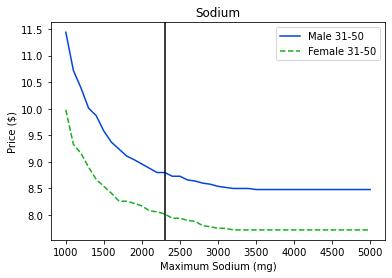

In [65]:
plt.plot(sodium_range, sodium_costs['M 31-50'], color='xkcd:blue', label='Male 31-50', linestyle='solid')
plt.plot(sodium_range, sodium_costs['F 31-50'], color='xkcd:green', label='Female 31-50', linestyle='dashed')
plt.axvline(x=2300, color='xkcd:black')
plt.legend()
plt.title("Sodium")
plt.xlabel("Maximum Sodium (mg)")
plt.ylabel("Price ($)")
plt.savefig('sodium.png', dpi=300)
plt.show()

In [36]:
print(sodium_costs)

{'M 31-50': [11.440000000000003, 10.720000000000002, 10.39, 10.009999999999998, 9.869999999999997, 9.579999999999998, 9.37, 9.239999999999998, 9.11, 9.04, 8.959999999999999, 8.879999999999999, 8.8, 8.8, 8.729999999999999, 8.729999999999999, 8.66, 8.639999999999999, 8.6, 8.58, 8.54, 8.52, 8.499999999999998, 8.499999999999998, 8.5, 8.479999999999999, 8.48, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999, 8.479999999999999], 'F 31-50': [9.98, 9.33, 9.159999999999998, 8.899999999999999, 8.670000000000002, 8.54, 8.41, 8.26, 8.26, 8.219999999999999, 8.17, 8.08, 8.06, 8.02, 7.9399999999999995, 7.9399999999999995, 7.9, 7.879999999999999, 7.799999999999999, 7.7799999999999985, 7.749999999999999, 7.749999999999999, 7.719999999999999, 7.719999999999999, 7.719999999999999, 7.72, 7.719999999999999, 7.72,

In [37]:
end_time = time.time()

print(f'Total Running Time So Far: {(end_time-start_time)//60} minutes {(end_time-start_time)%60} seconds')

Total Running Time So Far: 14.0 minutes 36.68031454086304 seconds


In [38]:
satfat_range = np.linspace(0, 350, 36)
satfat_results = {}

for satfat in satfat_range:
    opt = NutOptimizer(data=level_2_dat)
    opt.load_constraints_json(fp)
    
    add_category_constraints(opt, include_mins, max_per_category)
    # Vary Constraints as necessary
    for model in models:
        opt.update_constraint(model, 'Fatty acids, total saturated', 'max', satfat)
    # Do the optimization
    for model in models:
        opt.optimize_one(model, 'Price per Serving', 'INTEGER', verbose=False, timeout=3600)        
    
    # Record the results
    for model in models:
        if model not in satfat_results:
            satfat_results[model] = {}
            satfat_results[model]['cost'] = {}
            satfat_results[model]['prods'] = {}
        satfat_results[model]['cost'][satfat] = opt.get_one_optimal_value(model, 'Price per Serving')
        satfat_results[model]['prods'][satfat] = opt.get_one_result(model)

In [39]:
satfat_costs = {}

for model in ['M 31-50', 'F 31-50']:
    satfat_costs[model] = []
    for i in satfat_range:
        satfat_costs[model].append(satfat_results[model]['cost'][i])

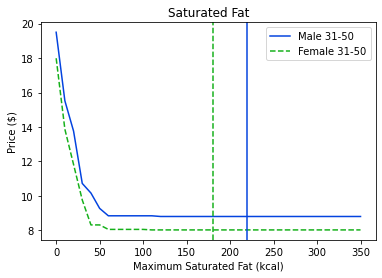

In [40]:
plt.plot(satfat_range, satfat_costs['M 31-50'], color='xkcd:blue', label='Male 31-50', linestyle='solid')
plt.plot(satfat_range, satfat_costs['F 31-50'], color='xkcd:green', label='Female 31-50', linestyle='dashed')
plt.axvline(x=180, color='xkcd:green', linestyle='dashed')
plt.axvline(x=220, color='xkcd:blue', linestyle='solid')
plt.legend()
plt.title("Saturated Fat")
plt.xlabel("Maximum Saturated Fat (kcal)")
plt.ylabel("Price ($)")
plt.savefig('satfat.png', dpi=300)
plt.show()

In [41]:
end_time = time.time()

print(f'Total Running Time So Far: {(end_time-start_time)//60} minutes {(end_time-start_time)%60} seconds')

Total Running Time So Far: 27.0 minutes 27.799599409103394 seconds


In [42]:
sugar_range = np.linspace(50, 400, 36)
sugar_results = {}

for sugar in sugar_range:
    opt = NutOptimizer(data=level_2_dat)
    opt.load_constraints_json(fp)
    
    add_category_constraints(opt, include_mins, max_per_category)
    # Vary Constraints as necessary
    for model in models:
        opt.update_constraint(model, 'Sugars, added', 'max', sugar)
    # Do the optimization
    for model in models:
        opt.optimize_one(model, 'Price per Serving', 'INTEGER', verbose=False, timeout=3600)        
    
    # Record the results
    for model in models:
        if model not in sugar_results:
            sugar_results[model] = {}
            sugar_results[model]['cost'] = {}
            sugar_results[model]['prods'] = {}
        sugar_results[model]['cost'][sugar] = opt.get_one_optimal_value(model, 'Price per Serving')
        sugar_results[model]['prods'][sugar] = opt.get_one_result(model)

In [43]:
sugar_costs = {}

for model in ['M 31-50', 'F 31-50']:
    sugar_costs[model] = []
    for i in sugar_range:
        sugar_costs[model].append(sugar_results[model]['cost'][i])

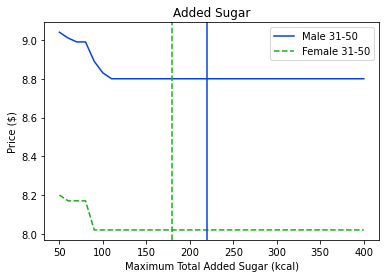

In [44]:
plt.plot(sugar_range, sugar_costs['M 31-50'], color='xkcd:blue', label='Male 31-50', linestyle='solid')
plt.plot(sugar_range, sugar_costs['F 31-50'], color='xkcd:green', label='Female 31-50', linestyle='dashed')
plt.axvline(x=180, color='xkcd:green', linestyle='dashed')
plt.axvline(x=220, color='xkcd:blue', linestyle='solid')
plt.legend()
plt.title("Added Sugar")
plt.xlabel("Maximum Total Added Sugar (kcal)")
plt.ylabel("Price ($)")
plt.savefig('sugar.png', dpi=300)
plt.show()

In [45]:
end_time = time.time()

print(f'Total Running Time So Far: {(end_time-start_time)//60} minutes {(end_time-start_time)%60} seconds')

Total Running Time So Far: 39.0 minutes 30.112244129180908 seconds


# Table with Changing Tolerances

In [46]:
def color(val):
    if not isinstance(val, bool):
        return 'color: black'
    if val:
        return 'color: blue'
    return 'color: red'

## Level 2 Data

In [47]:
level_2_opt.load_constraints_json(fp)
add_category_constraints(level_2_opt, include_mins, max_per_category)

In [48]:
tolerances = [0.0, .025, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]

In [49]:
level_2_original_const = level_2_opt.constraints
adjust_min = True
adjust_max = True

level_2_cost_dict = {}

for model in ['M 31-50', 'F 31-50']:
    level_2_cost_dict[model] = {}
    for tolerance in tolerances:
        level_2_cost_dict[model][tolerance] = {}
        for const in level_2_original_const[model]:
            if const in cats['Final Category'].unique() or const == 'Energy - kcal':
                continue
            for const_type in level_2_original_const[model][const]:
                if const_type == 'max':
                    if adjust_max:
                        level_2_opt.update_constraint(model, const, const_type, level_2_original_const[model][const][const_type]*(1+tolerance))
                elif const_type == 'min':
                    if adjust_min:
                        level_2_opt.update_constraint(model, const, const_type, level_2_original_const[model][const][const_type]*(1-tolerance))
        
        level_2_opt.optimize_one(model, 'Price per Serving', verbose=False, var_type='INTEGER')
        level_2_cost_dict[model][tolerance]['Cost'] = level_2_opt.get_one_optimal_value(model, 'Price per Serving')
        for nutrient in level_2_original_const[model]:
            if nutrient not in cats['Final Category'].unique():
                level_2_cost_dict[model][tolerance][nutrient] = level_2_opt.get_one_optimal_value(model, nutrient)

        level_2_opt.load_constraints_json(fp)
        add_category_constraints(level_2_opt, True, 2)

In [50]:
level_2_tf_cost_dict = {}

for model in ['M 31-50', 'F 31-50']:
    level_2_tf_cost_dict[model] = {}
    for tolerance in level_2_cost_dict[model]:
        level_2_tf_cost_dict[model][tolerance] = {}
        for const in level_2_cost_dict[model][tolerance]:
            if const == 'Cost': 
                level_2_tf_cost_dict[model][tolerance][const] = level_2_cost_dict[model][tolerance][const]
                continue
            if const == 'Energy - kcal':
                continue
            mini = level_2_original_const[model][const].get('min') if level_2_original_const[model][const].get('min') else 0
            optimal = level_2_cost_dict[model][tolerance][const]
            maxi = level_2_original_const[model][const].get('max') if level_2_original_const[model][const].get('max') else np.inf
            level_2_tf_cost_dict[model][tolerance][const] = mini <= optimal <= maxi

In [51]:
print("F 31-50 Level 2")
df = pd.DataFrame(level_2_tf_cost_dict['F 31-50'])
df.style.applymap(color)

F 31-50 Level 2


,0.0,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5
Cost,8.020000,7.940000,7.800000,6.990000,6.690000,6.020000,5.420000,5.110000,4.220000,3.530000
Protein - cal,True,True,True,True,True,True,True,True,True,True
Protein - g,True,True,True,True,True,True,True,True,True,True
Carb - cal,True,False,False,False,True,True,True,True,True,True
Total Carbohydrate,True,True,True,True,True,True,True,True,True,True
"Fiber, total dietary",True,True,True,True,True,False,True,False,False,False
"Sugars, added",True,True,True,True,True,True,True,True,True,True
Total lipid (fat),True,True,True,True,True,True,True,True,True,True
"Fatty acids, total saturated",True,True,True,True,True,False,False,False,True,False
"Calcium, Ca",True,True,True,False,True,True,True,True,False,False


In [52]:
print("M 31-50 Level 2")
df = pd.DataFrame(level_2_tf_cost_dict['M 31-50'])
df.style.applymap(color)

M 31-50 Level 2


,0.0,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5
Cost,8.800000,8.730000,8.650000,8.200000,7.500000,7.230000,6.780000,6.490000,4.830000,4.190000
Protein - cal,True,True,True,True,True,True,True,True,True,True
Protein - g,True,True,True,True,True,True,True,True,True,True
Carb - cal,True,True,True,True,False,True,False,True,False,False
Total Carbohydrate,True,True,True,True,True,True,True,True,True,True
"Fiber, total dietary",True,True,True,False,False,True,True,True,True,False
"Sugars, added",True,True,True,False,False,True,False,True,True,True
Total lipid (fat),True,True,True,True,True,True,True,True,True,True
"Fatty acids, total saturated",True,True,True,False,False,True,True,False,False,False
"Calcium, Ca",True,True,True,True,True,True,True,True,True,False


In [53]:
rows = dat.shape[0]
for col in level_2_tf_cost_dict['M 31-50'][0]:
    if col == 'Cost':
        continue
    print(f'{col}: {round(100*(dat[col]==0).sum()/rows,2)}%')

Protein - cal: 26.66%
Protein - g: 26.66%
Carb - cal: 10.28%
Total Carbohydrate: 10.28%
Fiber, total dietary: 44.56%
Sugars, added: 65.8%
Total lipid (fat): 30.79%
Fatty acids, total saturated: 44.29%
Calcium, Ca: 41.27%
Iron, Fe: 40.24%
Magnesium, Mg: 96.17%
Phosphorus, P: 96.03%
Potassium, K: 47.75%
Sodium, Na: 12.09%
Zinc, Zn: 97.17%
Vitamin A, IU: 87.26%
Vitamin E: 99.15%
Vitamin D (D2 + D3), International Units: 97.68%
Vitamin C, total ascorbic acid: 85.25%
Thiamin: 97.17%
Riboflavin: 93.94%
Niacin: 92.27%
Vitamin K (phylloquinone): 99.39%
Folic acid: 96.81%
Vitamin B-6: 95.23%
Vitamin B-12: 96.0%
Protein Foods_wt_in_g: 92.66%
Grains_wt_in_g: 92.54%


In [54]:
end_time = time.time()

print(f'Total Notebook Running Time: {(end_time-start_time)//60} minutes {(end_time-start_time)%60} seconds')

Total Notebook Running Time: 43.0 minutes 4.808959007263184 seconds


In [69]:
# from PIL import Image
# from io import BytesIO
# import imageio as iio

# file = 'dataset.png'
# img = Image.open(file)
# img.convert("RGB").save(f"{file}", "PNG", dpi=(300,300))